In [1]:
# Import required libraries.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# Enable eagor execution.
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense

# Show plots inside of the notebook.
#%matplotlib inline
import matplotlib.pyplot as plt

# Load from local drive
# df=pd.read_csv('malaysia_all_data_for_paper.csv', sep=';', index_col='time', parse_dates=True) 

#file_id='1VTPXEplsH1qXQGXa5RA8AX0hGnsnrIH5' 
#link='https://drive.google.com/uc?export=download&id={FILE_ID}'
#csv_url=link.format(FILE_ID=file_id)
df = pd.read_csv('malaysia_all_data_for_paper.csv', sep=';', index_col='time', parse_dates=True)

# Function for Min-Max Normalization.
def min_max_norm(dataset_train, dataset_test):
    """
    Min-Max Normalization.

    Parameters
    ----------
    dataset_train: Train data.
    dataset_test: Test data.

    Returns
    -------
    Normalized datasets. 

    """
    dataset_max = dataset_train.max()
    dataset_min = dataset_train.min()
    
    dataset_train_std = (dataset_train - dataset_min)/(dataset_max - dataset_min)
    dataset_test_std = (dataset_test - dataset_min)/(dataset_max - dataset_min)
    
    return dataset_train_std, dataset_test_std



    # Function to reshape the data to feed into RNN model.
def reshape(dataset, target, history_step, target_step, single_step=False):
    """
    Reshape the data to RNN model accepted dimension. 
    
    Parameters
    ----------
    dataset: Original input dataset X.
    target: Output dataset y.
    history_step: Length of history steps used as model input. 
    target_step: Steps to predict from the end index of one input set. 
    single_step: If single_step=True, output y is one value at end_index + target_step.
                 If single_step=False, output y is a list of value from end_index to end_index + target_step.

    Returns
    -------
    x: Reshaped x.
    y: Reshaped y.
    """
    n = dataset.shape[0]
    if len(dataset.shape) == 1:
        num_features = 1
    else:
        num_features = dataset.shape[1]
    x, y = [], []
    
    x_start_index, x_end_index = 0, n - history_step - target_step
    
    for i in range(x_start_index, x_end_index):
        indices = range(i, i + history_step)
        x.append(np.reshape(dataset[indices], (history_step, num_features)))
        if single_step:
            y.append(target[i + history_step + target_step])
        else:
            y.append(target[i + history_step: i + history_step + target_step])
    
    return np.array(x), np.array(y)

In [3]:
# Train test split. The last 20% of data are used for testing.
TEST_SPLIT = int(df.shape[0] * 0.8)
df_train, df_test = df[:TEST_SPLIT], df[TEST_SPLIT:]
df_train_std, df_test_std = min_max_norm(df_train, df_test)

# Use input data from previous 24 hours to predict next hour loading.
history_step = 24 
target_step = 0

# Batch parameters.
val_split=0.8
batch_size=256
buffer_size=10000

# RNN model parameters.
layers = 2
num_unit = 16
EVALUATION_INTERVAL = 100
EPOCHS = 50
VALIDATION_STEPS = 20

# Only use loading column for prediction.
uni_train_std, uni_test_std = df_train_std.values, df_test_std.values

# Prepare X, y for training.
x_train_uni, y_train_uni = reshape(uni_train_std[:,0], uni_train_std[:,1], history_step, target_step, single_step=True)
x_test_uni, y_test_uni = reshape(uni_test_std[:,0], uni_test_std[:,1], history_step, target_step, single_step=True)

In [4]:
# Function to shuffle and cache the train and validation data batch.
def data_batch(x, y, val_split=0.8, batch_size=256, buffer_size=10000):
    
    split_index = int(x.shape[0] * val_split)
    #将数据和标签对应
    train = tf.data.Dataset.from_tensor_slices((x[:split_index], y[:split_index]))
    validation = tf.data.Dataset.from_tensor_slices((x[split_index:], y[split_index:]))

    # Construct batch data.
    train_batch = train.cache().shuffle(buffer_size).batch(batch_size).repeat()
    val_batch = validation.cache().shuffle(buffer_size).batch(batch_size).repeat()

    return train_batch, val_batch


    # Train and validation batch
train_batch, val_batch = data_batch(x_train_uni, y_train_uni)

In [5]:
def lstm_model(layers, num_unit, input_shape, output_size, optimizer='adam', loss='mae'):
    """
    Construct RNN model with LSTM cell
    
    Parameters
    ----------
    layers: layers of LSTM in the model.
    num_unit: Positive integer, dimensionality of the output space.
    input_shape: 
    output_size: 
    optimizer:
    loss:

    Returns
    -------
    LSTM model.
    """
    #Sequential()方法是一个容器，描述了神经网络的网络结构，在Sequential()的输入参数中描述从输入层到输出层的网络结构
    model = tf.keras.models.Sequential()
    
    for i in range(layers - 1):
        model.add(LSTM(num_unit, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(num_unit, input_shape=input_shape))
    model.add(Dense(output_size))                    # Output layer.
    
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

In [6]:
# Univariant model.
uni_model = lstm_model(layers, num_unit, x_train_uni.shape[-2:], target_step+1)

uni_history = uni_model.fit(train_batch, 
                             epochs=EPOCHS,
                             steps_per_epoch=EVALUATION_INTERVAL,
                             validation_data=val_batch, 
                             validation_steps=VALIDATION_STEPS)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
100/100 [==============================] - 13s 129ms/step - loss: 0.2536 - val_loss: 0.2082
Epoch 2/50
100/100 [==============================] - 8s 80ms/step - loss: 0.1553 - val_loss: 0.1296
Epoch 3/50
100/100 [==============================] - 7s 75ms/step - loss: 0.1183 - val_loss: 0.1195
Epoch 4/50
100/100 [==============================] - 8s 82ms/step - loss: 0.1140 - val_loss: 0.1187
Epoch 5/50
100/100 [==============================] - 8s 81ms/step - loss: 0.1106 - val_loss: 0.1230
Epoch 6/50
100/100 [==============================] - 8s 82ms/step - loss: 0.1100 - val_loss: 0.1144
Epoch 7/50
100/100 [==============================] - 8s 80ms/step - loss: 0.1064 - val_loss: 0.1135
Epoch 8/50
100/100 [==============================] - 8s 81ms/step - loss: 0.10

In [7]:
def mse_calc(a, b):
    n = len(a)
    res = sum([(a[i] - b[i])**2 for i in range(n)]) / n
    return res


# Prediction on test dataset and calculate loss.
uni_pred = uni_model.predict(x_test_uni)

uni_mse = mse_calc(uni_pred, y_test_uni)

print('Mean Square Error on test data is: %4f' % uni_mse)


def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Mean Square Error on test data is: 0.102885


In [9]:
#多步预测
# Use same parameters as univariant prediction.
# Early stopping.
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.002,
                                           patience=3)

history_step = 168
target_step = 24    # Predict next day

# Batch parameters.
val_split=0.8
batch_size=256
buffer_size=10000

# RNN model parameters.
layers = 2
num_unit = 32
EVALUATION_INTERVAL = 200
EPOCHS = 50
VALIDATION_STEPS = 20

# Prepare X, y for training.
x_train_uni, y_train_uni = reshape(uni_train_std[:,0], uni_train_std[:,-1], history_step, target_step, single_step=False)
x_test_uni, y_test_uni = reshape(uni_test_std[:,0], uni_test_std[:,-1], history_step, target_step, single_step=False)

# Verify reshaped dataset shape:
print('Training X, y dataset shapes are:')
print(x_train_uni.shape, y_train_uni.shape)
print('Testing X, y dataset shapes are:')
print(x_test_uni.shape, y_test_uni.shape)

# Train and validation batch
train_batch, val_batch = data_batch(x_train_uni, y_train_uni)

# Build Model
uni_day_ahead_model = lstm_model(layers, num_unit, x_train_uni.shape[-2:], target_step, optimizer='RMSprop')

# Train model with early stopping.
uni_day_ahead_history = uni_day_ahead_model.fit(train_batch, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            callbacks=[earlystop_callback],
                                            validation_data=val_batch, 
                                            validation_steps=VALIDATION_STEPS)

Training X, y dataset shapes are:
(13823, 168, 1) (13823, 24)
Testing X, y dataset shapes are:
(3312, 168, 1) (3312, 24)
Epoch 1/50
200/200 [==============================] - 141s 705ms/step - loss: 0.1654 - val_loss: 0.1060
Epoch 2/50
200/200 [==============================] - 134s 671ms/step - loss: 0.1052 - val_loss: 0.1117
Epoch 3/50
200/200 [==============================] - 125s 626ms/step - loss: 0.0990 - val_loss: 0.0974
Epoch 4/50
200/200 [==============================] - 136s 681ms/step - loss: 0.0964 - val_loss: 0.1274
Epoch 5/50
200/200 [==============================] - 133s 663ms/step - loss: 0.0945 - val_loss: 0.1242
Epoch 6/50
200/200 [==============================] - 142s 709ms/step - loss: 0.0928 - val_loss: 0.0952
Epoch 7/50
200/200 [==============================] - 144s 719ms/step - loss: 0.0918 - val_loss: 0.0921
Epoch 8/50
200/200 [==============================] - 145s 726ms/step - loss: 0.0912 - val_loss: 0.0919
Epoch 9/50
200/200 [===========================

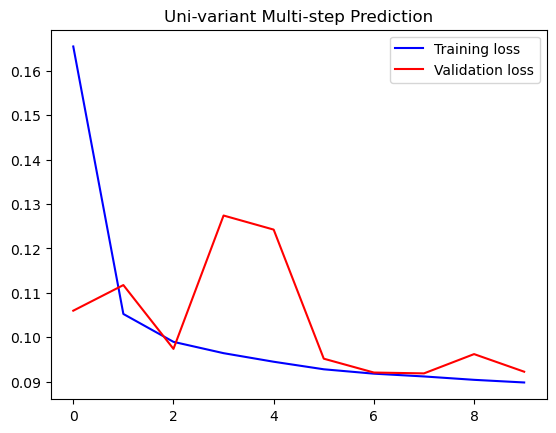

In [10]:
plot_train_history(uni_day_ahead_history, 'Uni-variant Multi-step Prediction')

In [13]:
# Function to generate comparison plot.

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [14]:
# Plot function for multi-step model.
def multi_step_plot(history, true_future, prediction, title):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.title(title)
    plt.plot(num_in, np.array(history), '.-', label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'b-', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'r-', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

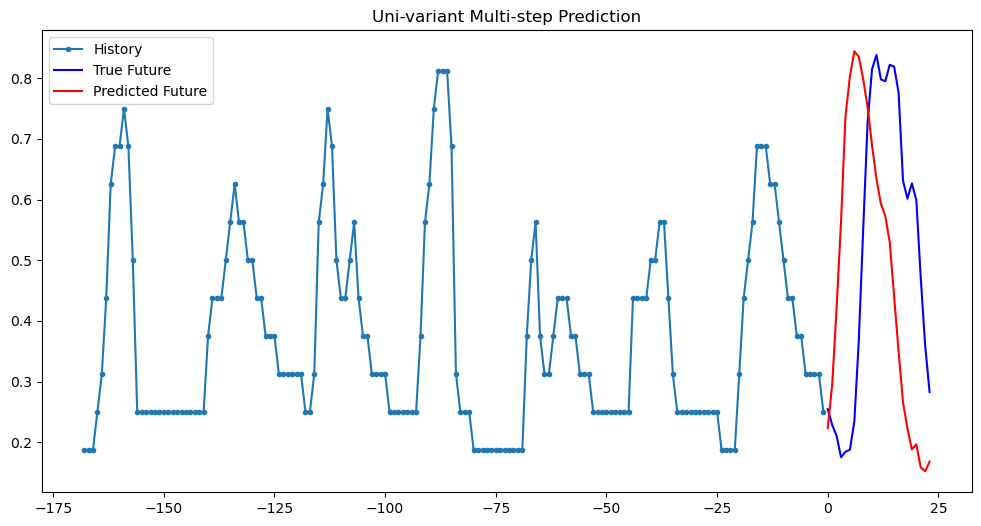

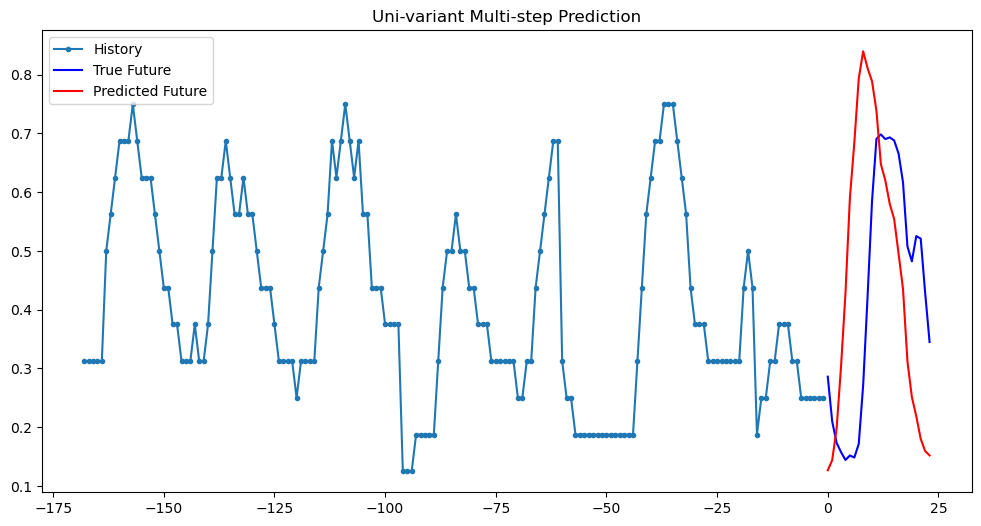

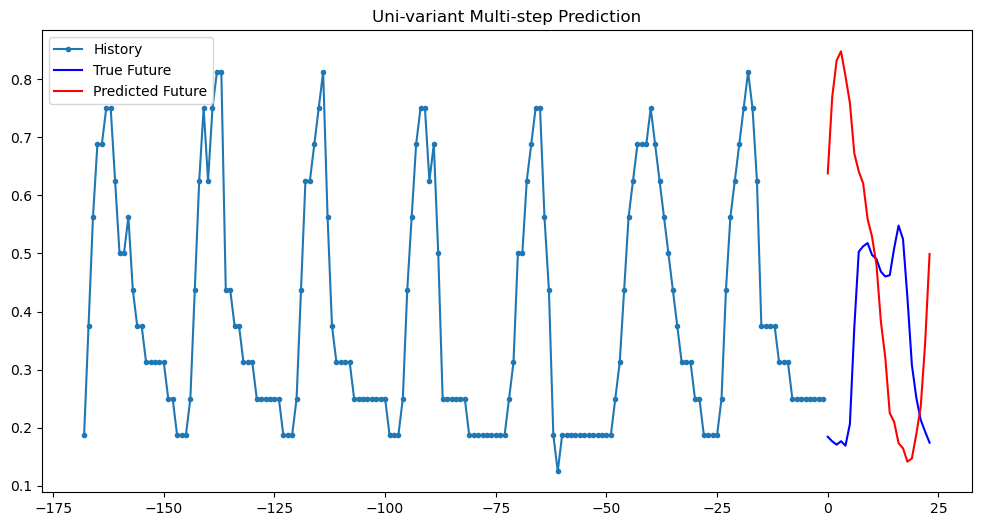

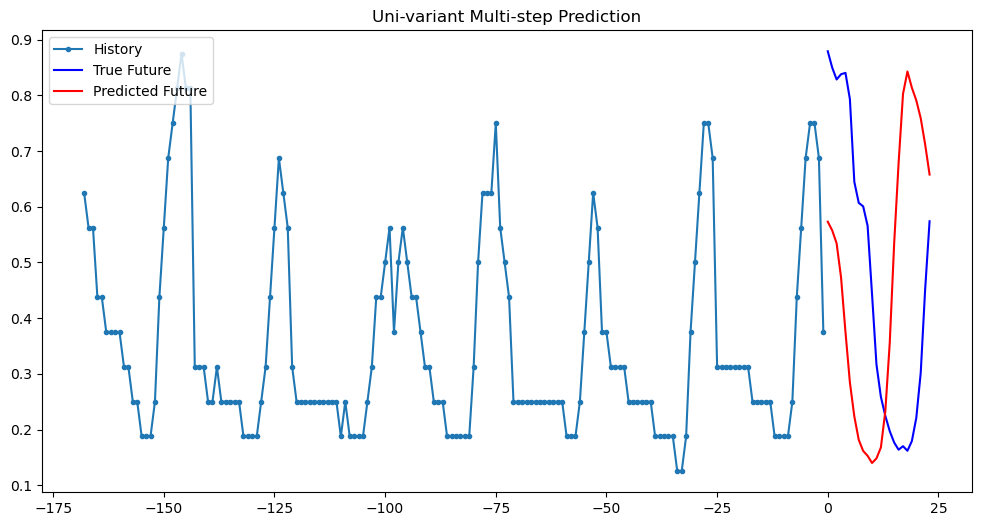

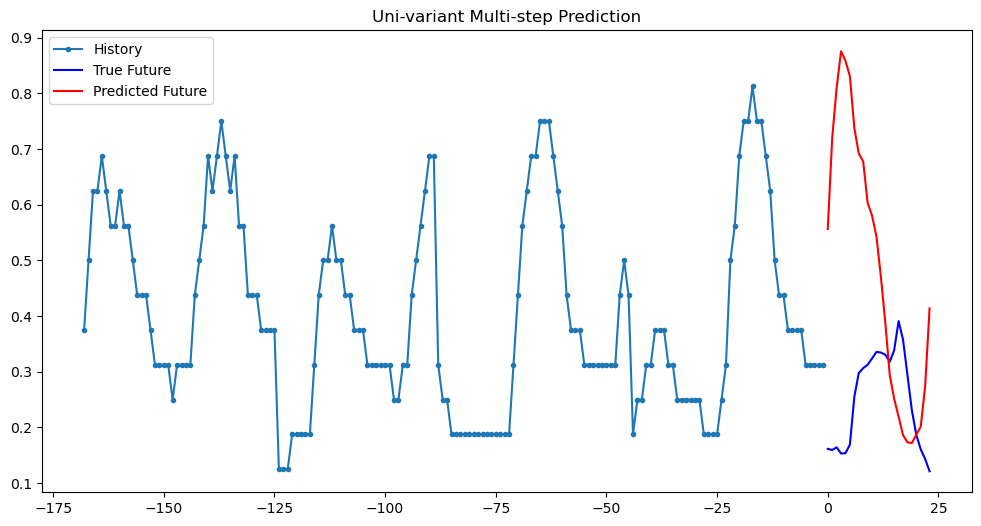

In [15]:
# Prediction
uni_day_ahead_pred = uni_day_ahead_model.predict(x_test_uni)

# Generate comparison plot for 5 random samples in testing dataset.
n = x_test_uni.shape[0]
rand = np.random.randint(n, size=5)

for i in rand:
    multi_step_plot(x_test_uni[i], y_test_uni[i], uni_day_ahead_pred[i], 'Uni-variant Multi-step Prediction')